In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import pickle as pkl

In [3]:
df = pd.read_csv("data/df_cleaned.csv")
stats_df = pd.read_csv("data/df_progress.csv")

In [13]:
with open('data/specific_stats.pkl', 'rb') as f:
    specific_stats = pkl.load(f)

with open('data/overall_stats.pkl', 'rb') as f:
    overall_stats = pkl.load(f)

In [69]:
def dist_measures(dist):
    mean = np.mean(dist)
    median = np.median(dist)
    std = np.std(dist)
    if std==0:
        skew = 0
    else:
        skew = 3*(mean-median)/std
    return [mean, median, skew, std]

def plt_dist(df, var, xlabel= None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    [m_mean, m_median, m_skew, m_std] = dist_measures(m_dist)
    [w_mean, w_median, w_skew, w_std] = dist_measures(w_dist)
    metric = "Mean" # default metric is mean
    m_metric = m_mean
    w_metric = w_mean
    # Assume skewness is >0 since there will be no negative values (FOR NOW)
    if m_skew > .5 or w_skew >.5: # if one of the distributions is skewed heavily..
        metric = "Median"
        m_metric = m_median
        w_metric = w_median

    if xlabel is None:
        xlabel = var.replace("_"," ").title()

    plt.hist(m_dist, alpha=0.4, label='Mens', color = 'blue') #0d98ba
    plt.hist(w_dist, alpha=0.4, label='Womens', color = 'orange') #7804b3
    
    plt.axvline(m_metric, color = 'blue', linestyle='dashed', linewidth=2)
    plt.axvline(w_metric, color='orange', linestyle='dashed', linewidth=2)
    plt.title("Dashed Line represents "+metric, fontsize = 7)
    plt.suptitle(var.replace("_"," ").title())
    plt.xlabel(xlabel)
    plt.ylabel("Matches")
    plt.legend(loc='upper right')
    plt.show()

In [70]:
specific_stats.remove('rs')
specific_stats.remove('seed')
specific_stats.remove('win')

Discrepancies between home and away?

In [71]:
print(sum(stats_df['rs_home']>stats_df['rs_away'])/len(stats_df)) # rank/seed not related to home/away designation

0.4846560846560847


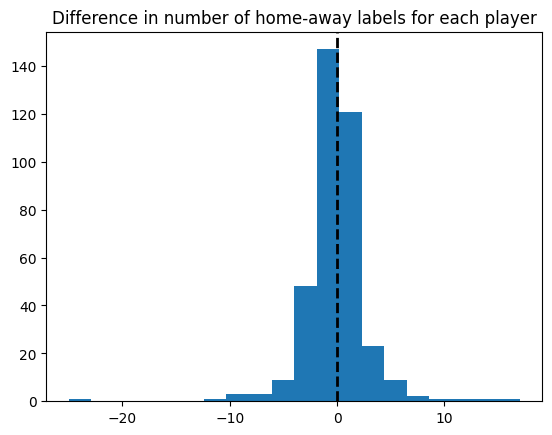

In [114]:
all_names = pd.DataFrame(pd.concat([df['name_home'], df['name_away']]), columns = ['name'])
all_names['home'] = [1 if x < len(df) else 0 for x in range(len(all_names))]
all_names['rank'] = pd.concat([df['rs_home'], df['rs_away']])
ranks = all_names.groupby('name')['rank'].mean().round()
all_names = all_names.drop(columns = ['rank'])
counts = pd.DataFrame(all_names.groupby('name').value_counts()).reset_index()
counts = counts.pivot(index='name', columns='home', values='count')
counts = counts.fillna(0)
counts['count_difference'] = counts[1] - counts[0]
plt.hist(counts['count_difference'], bins = 20)
plt.axvline(np.mean(counts['count_difference']), linestyle='dashed', color='black', linewidth=2)
plt.title("Difference in number of home-away labels for each player");

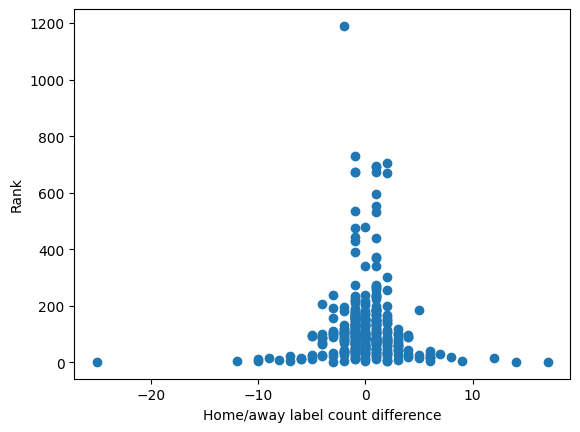

In [120]:
counts['ranks'] = ranks
plt.scatter(counts['count_difference'], counts['ranks'])
plt.xlabel("Home/away label count difference")
plt.ylabel("Rank");

# This suggests that players with higher rank are more likely to consistently be labeled as home or away player, compared to lower ranked players

In [121]:
features_diff = []
for stat in specific_stats:
    stats_df[stat+"_diff"] = stats_df[stat+h]-stats_df[stat+a] # abs() commented out
    features_diff.append(stat+"_diff")

features_diff.append("avg_set_diff")

for x in [x for x in overall_stats if x not in ['match_length','sets','men']]:
    features_diff.append(x)


/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_23015/1064959028.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_df[stat+"_diff"] = stats_df[stat+h]-stats_df[stat+a] # abs() commented out
/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_23015/1064959028.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_df[stat+"_diff"] = stats_df[stat+h]-stats_df[stat+a] # abs() commented out
/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_23015/1064959028.py:3: PerformanceWarning: DataFrame is h

To aggregate errors or not?? Leads me to a question of which variables should stay and which should not
I will remove all variables that basically tell me nothing, mean and std around zero

In [122]:
# Remove features whose mean and variance < 1
to_remove = []
for feature in specific_stats:
    ms = dist_measures(stats_df[feature+"_diff"])
    ms_h = dist_measures(stats_df[feature+h])
    ms_a = dist_measures(stats_df[feature+a])
    if ms_h[0] < 1 and ms_h[0] < 1 and ms_h[3] < 1 and ms_a[3] <1:
        # print(feature)
        # print(ms_h)
        # print(ms_a)
        # plt_dist(stats, feature+h)
        to_remove.append(feature+"_diff")
        print("Removed "+feature+"_diff")

features_diff = list(set(features_diff) - set(to_remove))

Removed tiebreaks_won_diff
Removed volley_unforced_errors_diff
Removed volley_winners_diff
Removed lob_winners_diff
Removed overhead_stroke_errors_diff
Removed overhead_stroke_winners_diff
Removed return_errors_diff
Removed drop_shot_unforced_errors_diff
Removed return_winners_diff
Removed lob_unforced_errors_diff
Removed overhead_stroke_unforced_errors_diff
Removed drop_shot_winners_diff


In [133]:
features_diff

['forehand_winners_diff',
 'forehand_unforced_errors_diff',
 'second_serve_points_won_diff',
 'backhand_winners_diff',
 'max_points_in_a_row_diff',
 'forehand_errors_diff',
 'avg_set_diff',
 'service_points_won_diff',
 'service_points_lost_diff',
 'games_won_diff',
 'second_serve_successful_diff',
 'groundstroke_winners_diff',
 'avg_set_games',
 'service_games_won_diff',
 'first_serve_successful_diff',
 'backhand_errors_diff',
 'groundstroke_errors_diff',
 'backhand_unforced_errors_diff',
 'max_games_in_a_row_diff',
 'first_serve_points_won_diff',
 'breakpoints_won_diff',
 'points_won_from_last_10_diff',
 'avg_points_per_game',
 'avg_game_length',
 'groundstroke_unforced_errors_diff',
 'double_faults_diff',
 'avg_set_length',
 'points_won_diff',
 'total_breakpoints_diff',
 'aces_diff']

In [123]:
features_diff_df = stats_df[features_diff]

Check data points in features_diff for linearity

In [124]:
features_diff_df.head()

,forehand_winners_diff,forehand_unforced_errors_diff,second_serve_points_won_diff,backhand_winners_diff,max_points_in_a_row_diff,forehand_errors_diff,avg_set_diff,service_points_won_diff,service_points_lost_diff,games_won_diff,...,breakpoints_won_diff,points_won_from_last_10_diff,avg_points_per_game,avg_game_length,groundstroke_unforced_errors_diff,double_faults_diff,avg_set_length,points_won_diff,total_breakpoints_diff,aces_diff
0,6.000000,4.000000,-1.000000,1.0,0,1.500000,1.500000,1.500000,-4.000000,1.500000,...,0.500000,2.000000,6.913043,4.433333,5.500000,-1.000000,50.983333,5.5,2.000000,5.500000
1,-5.000000,-5.500000,2.500000,-2.0,1,3.000000,1.000000,6.000000,3.000000,1.000000,...,0.000000,1.000000,6.769231,5.549359,-10.500000,-0.500000,72.141667,3.0,-3.500000,0.500000
2,4.500000,-4.500000,1.000000,-0.5,2,-2.500000,2.500000,0.500000,-8.000000,2.500000,...,1.500000,2.000000,7.210526,5.354386,0.000000,0.000000,50.866667,8.5,2.000000,1.500000
3,3.333333,3.000000,-2.666667,1.0,3,-1.000000,0.666667,-0.333333,-2.333333,0.666667,...,0.333333,0.666667,7.187500,5.134896,2.666667,-0.666667,54.772222,2.0,0.000000,1.333333
4,-1.666667,-1.333333,3.333333,2.0,1,-1.666667,2.000000,3.666667,-2.333333,2.000000,...,1.000000,2.000000,6.600000,4.678333,-2.000000,-0.666667,46.783333,6.0,1.666667,0.333333


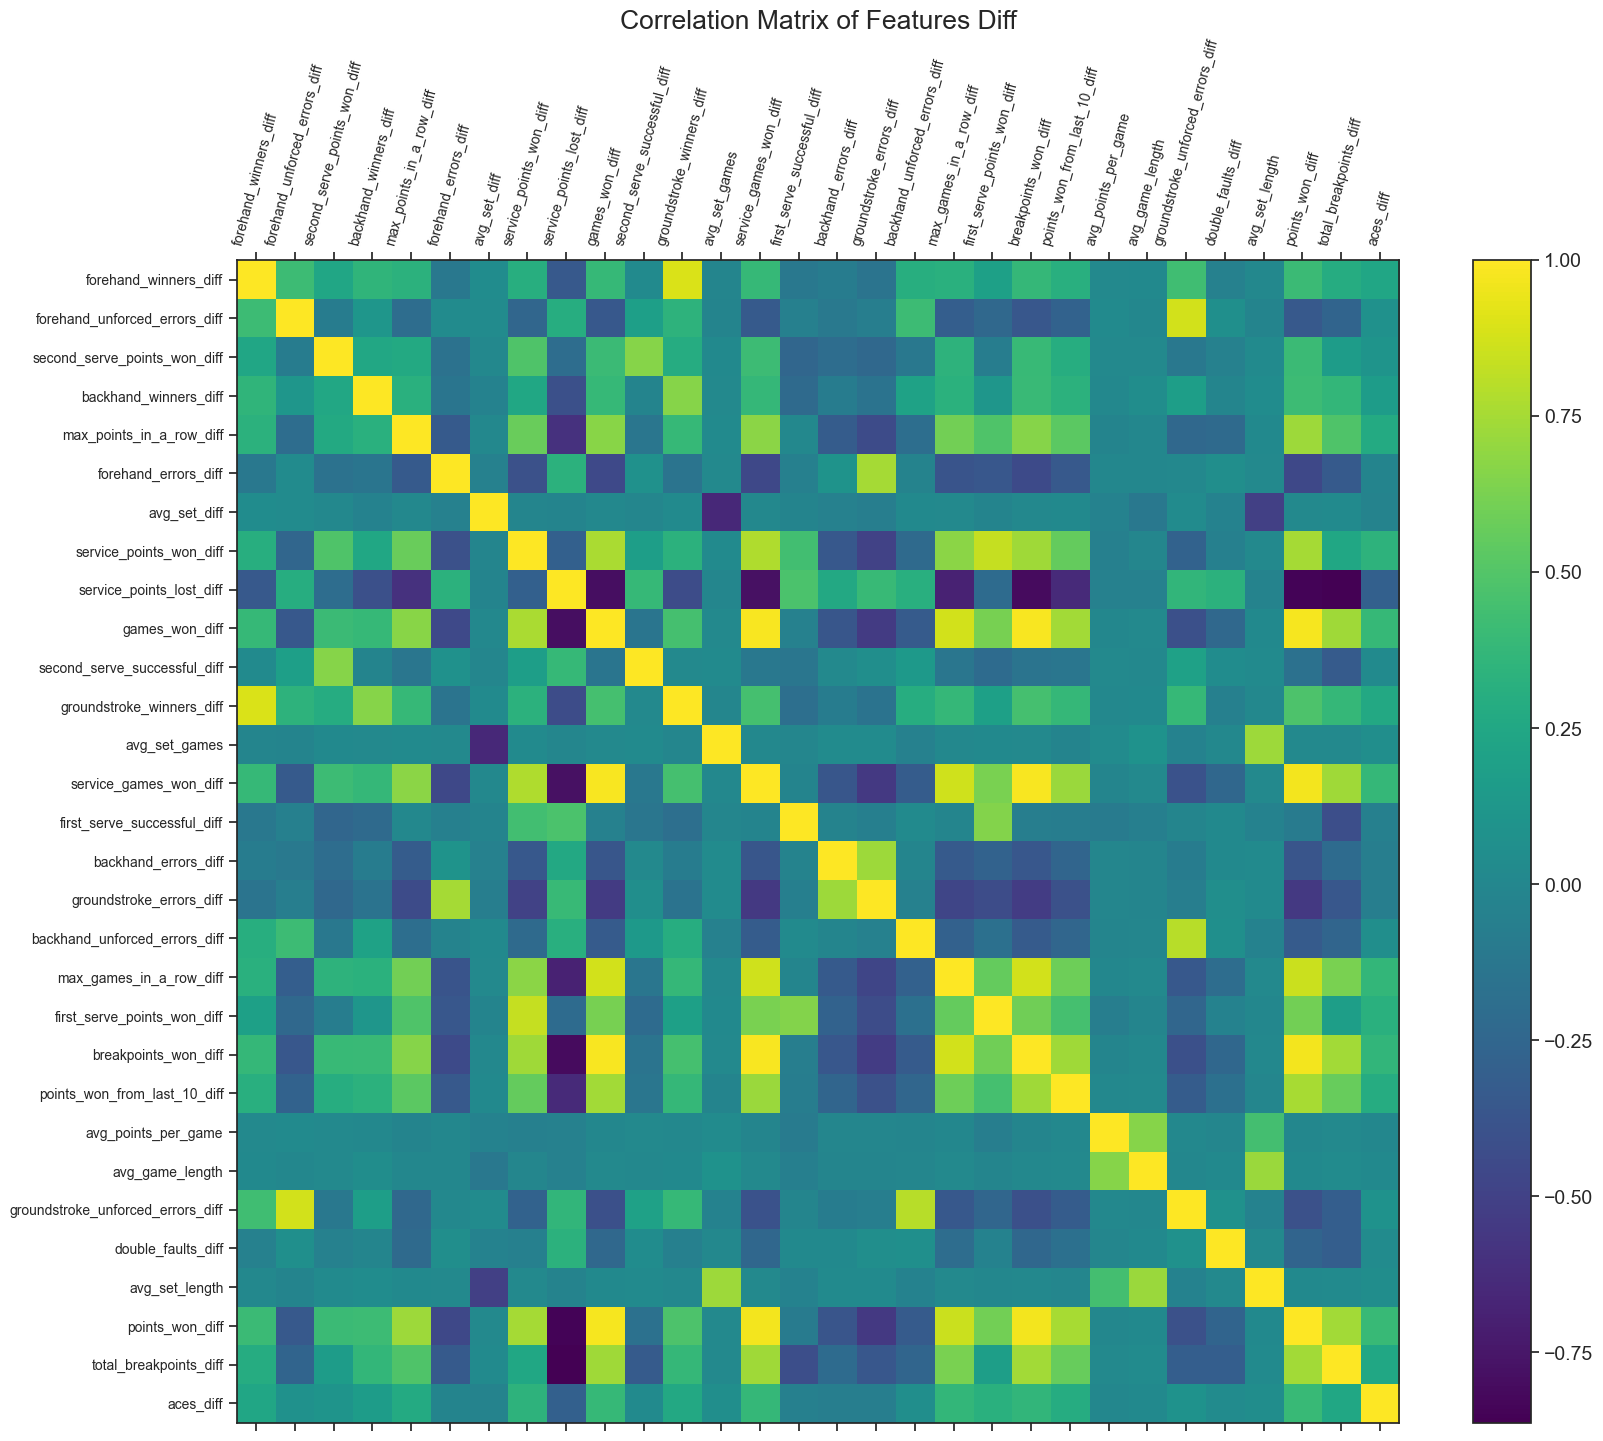

In [132]:
f = plt.figure(figsize=(19, 15))
matshow = plt.matshow(features_diff_df.corr(), fignum=f.number, cmap='viridis')
plt.xticks(range(features_diff_df.select_dtypes(['number']).shape[1]), features_diff_df.select_dtypes(['number']).columns, fontsize=10, rotation=75)
plt.yticks(range(features_diff_df.select_dtypes(['number']).shape[1]), features_diff_df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar(matshow)  # Use the matshow variable for the colorbar
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of Features Diff', fontsize=19);

In [136]:
#features_diff_df.columns

# to_try = ['aces_diff','double_faults_diff','points_won_diff','avg_points_per_game','avg_game_length','groundstroke_errors_diff','service_games_won_diff','breakpoints_won_diff','backhand_winners_diff','forehand_winners_diff']
to_try = ['service_points_won_diff',
'service_points_lost_diff',
'games_won_diff',
'groundstroke_winners_diff',
'service_games_won_diff',
'max_games_in_a_row_diff',
'first_serve_points_won_diff',
'breakpoints_won_diff',
'points_won_from_last_10_diff',
'points_won_diff',
'total_breakpoints_diff',
'groundstroke_errors_diff']


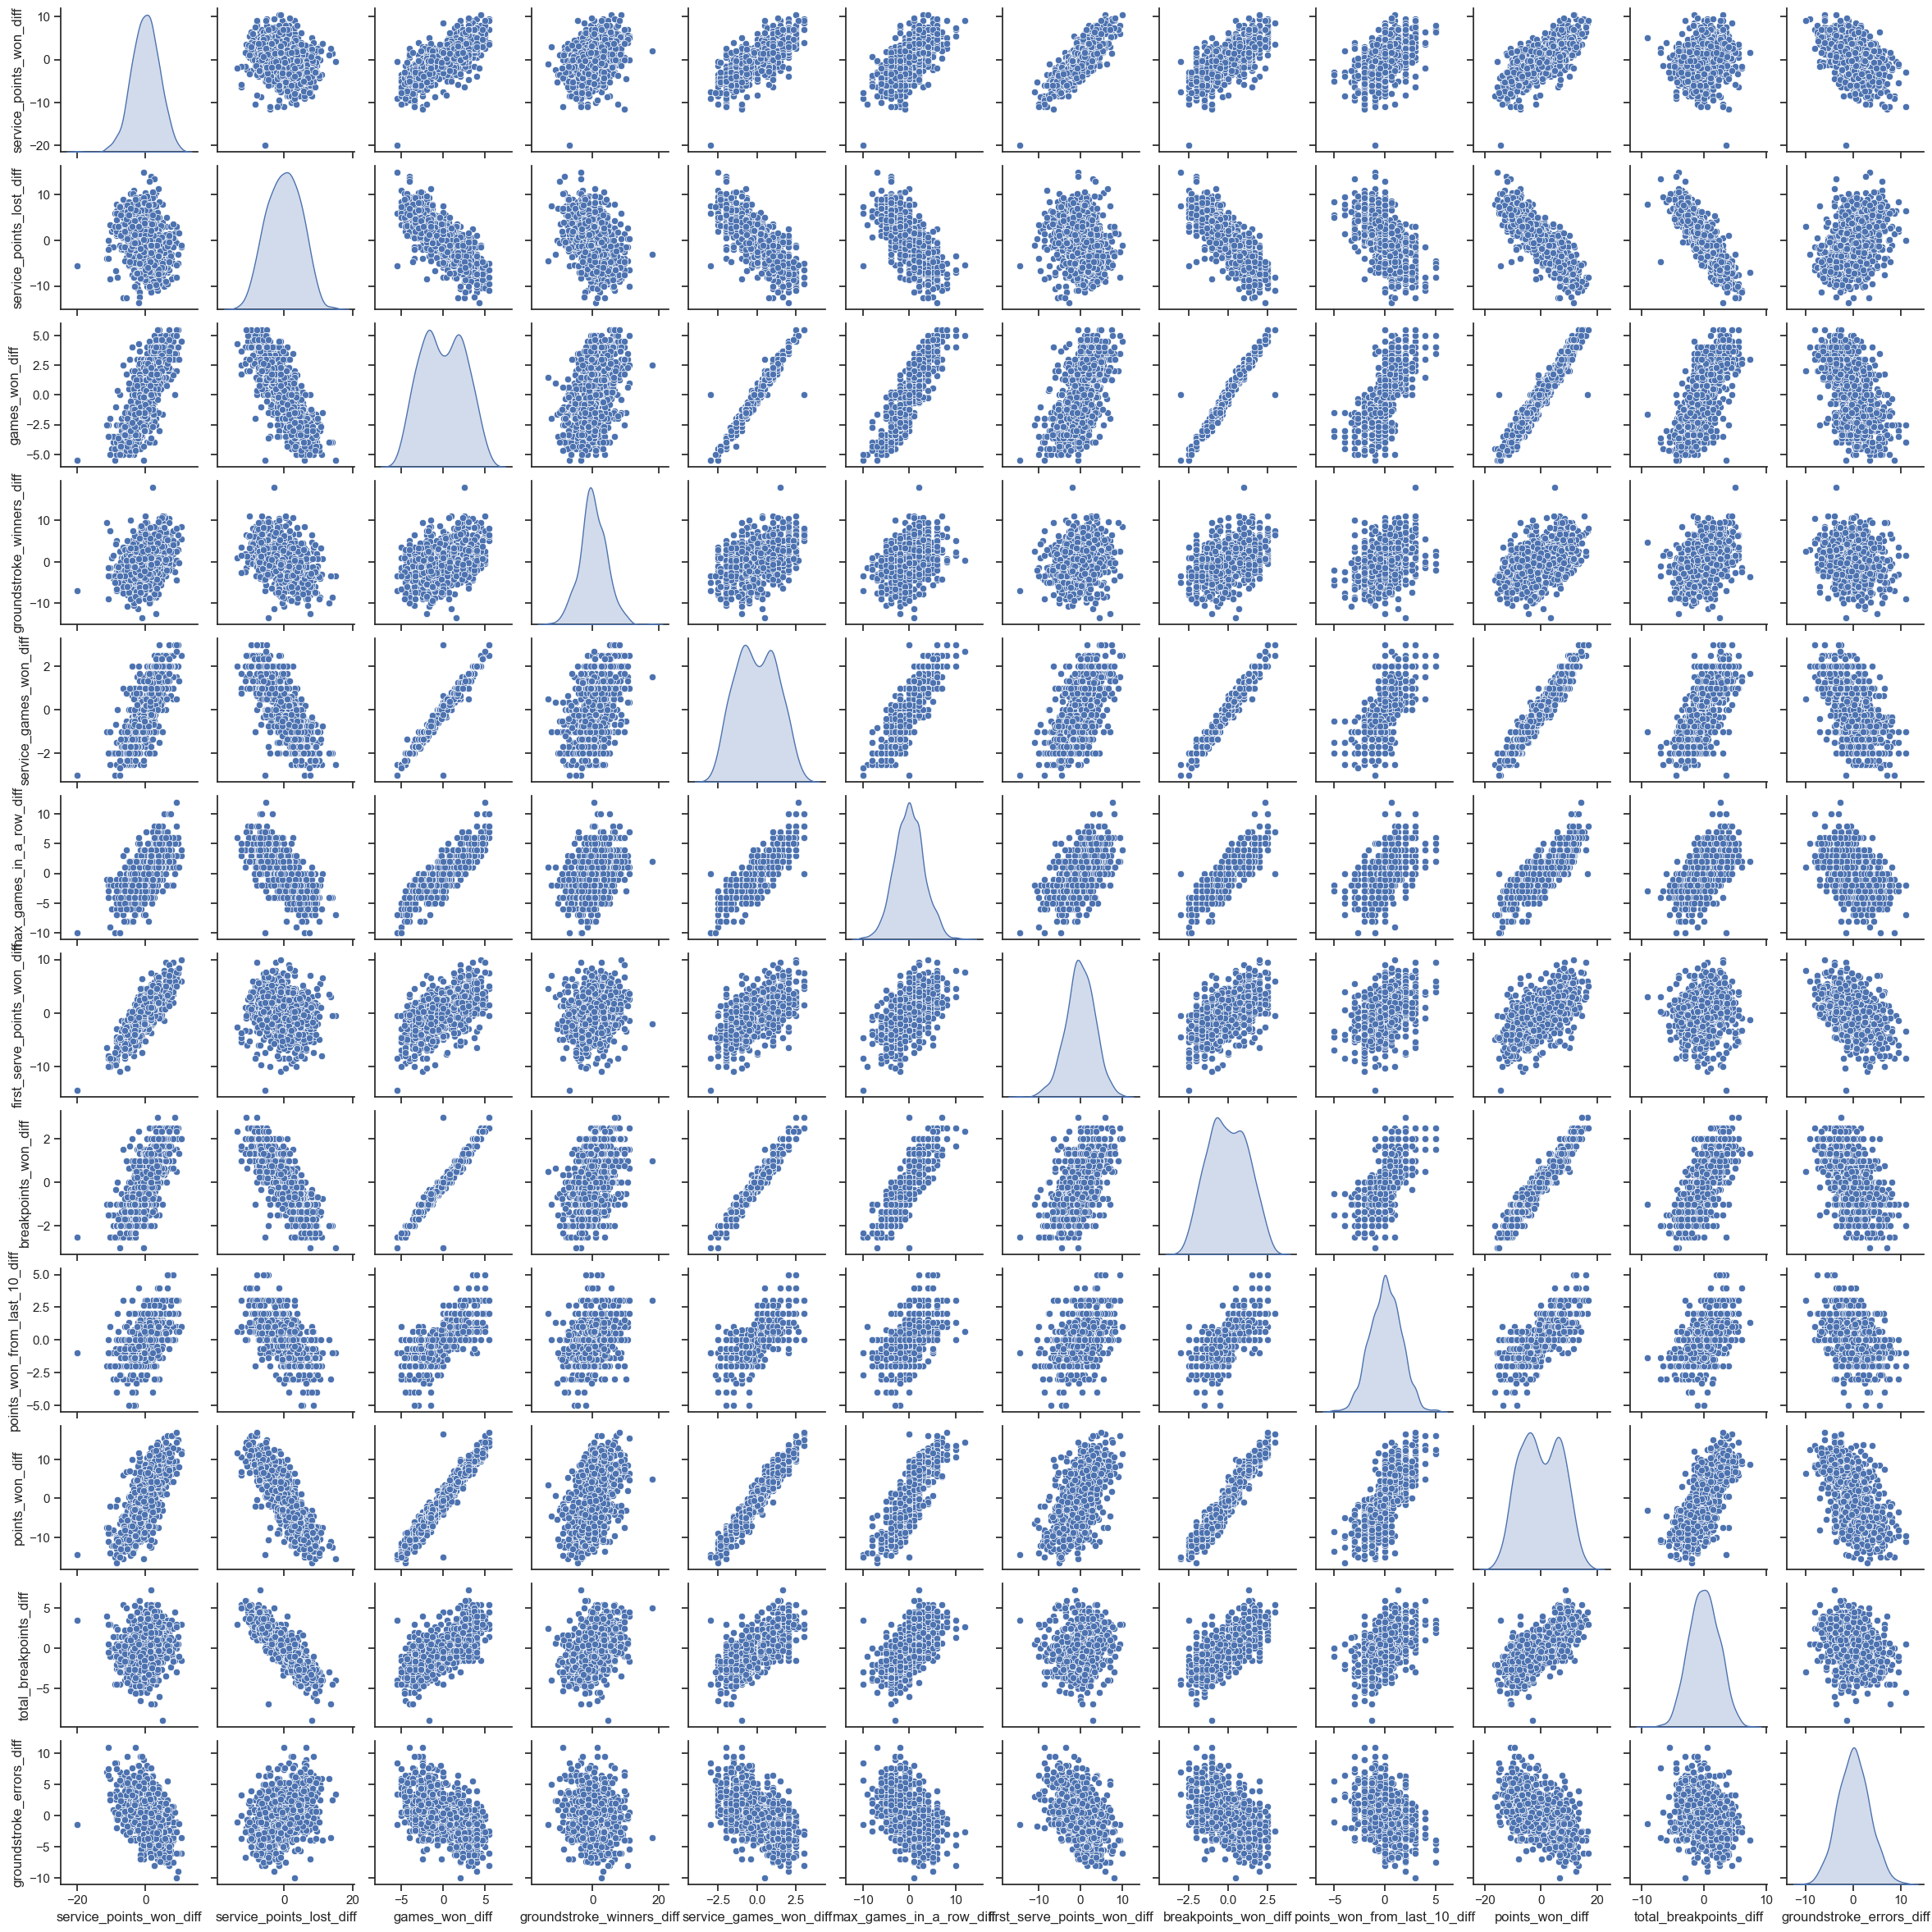

In [137]:
sns.set(style="ticks")
sns.pairplot(features_diff_df[to_try], height=2, markers='o', diag_kind='kde')

# Show the plots
plt.show()

In [152]:
features_diff_df_log = features_diff_df.copy()

for feature in to_try:
    features_diff_df_log[feature] = features_diff_df[feature].apply(lambda x: 0 if x == 0 else np.log(x))

/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_23015/1547471983.py:4: RuntimeWarning: invalid value encountered in log
  features_diff_df_log[feature] = features_diff_df[feature].apply(lambda x: 0 if x == 0 else np.log(x))


In [ ]:
sns.set(style="ticks")
sns.pairplot(features_diff_df_log[to_try], height=2, markers='o', diag_kind='kde')

# Show the plots
plt.show()

Checking for normativity

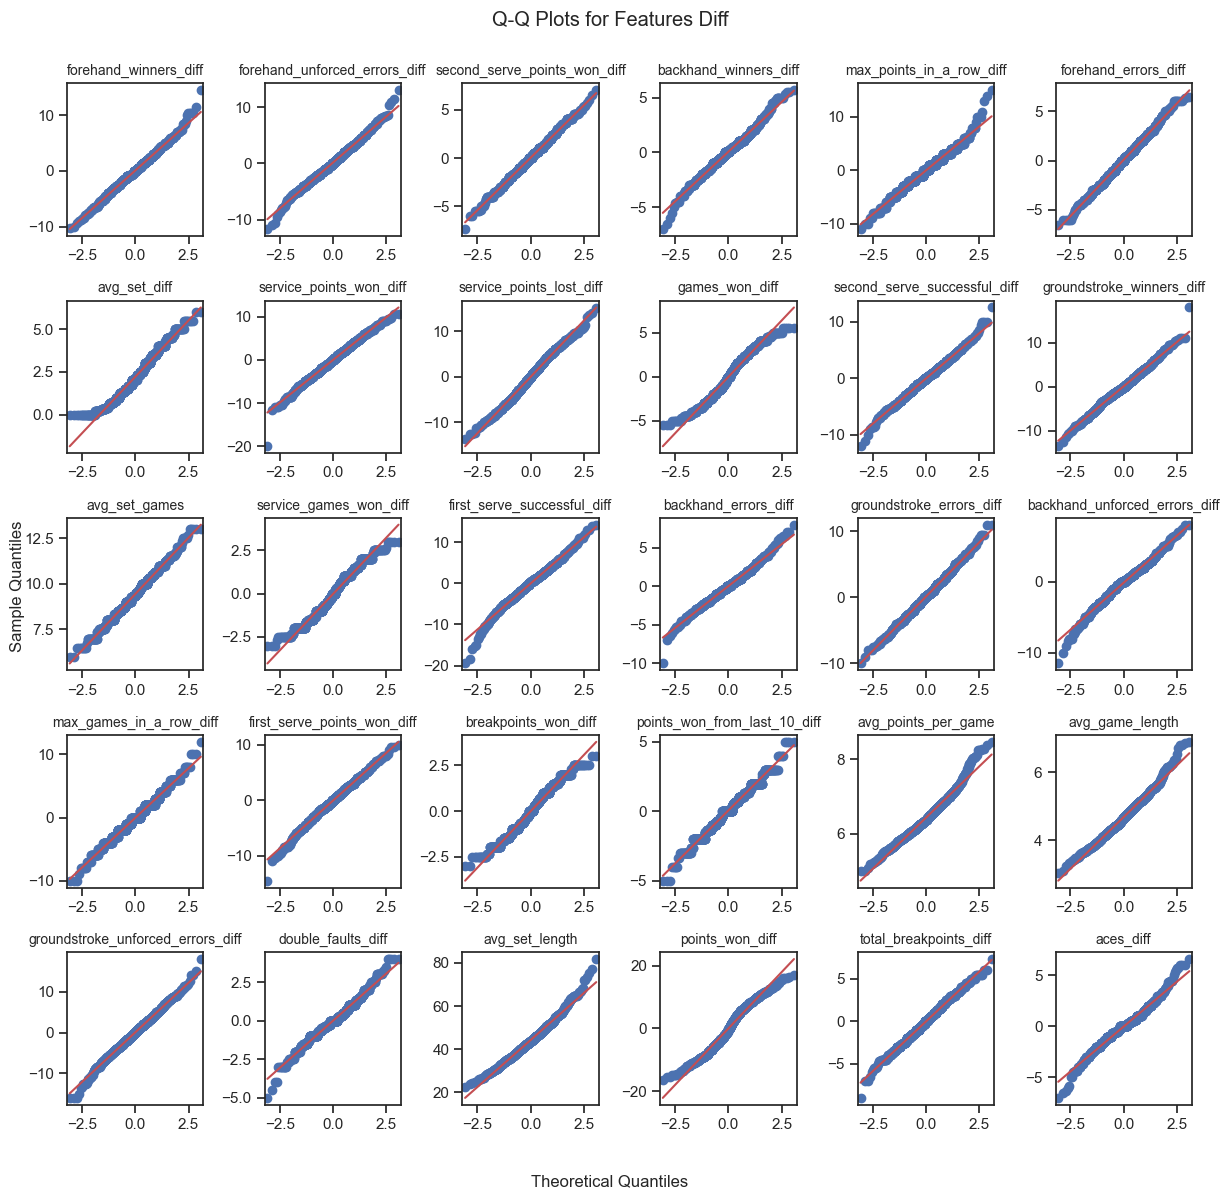

In [151]:
def disp_qq(df, row, col, name):
    # Create a grid of Q-Q plots
    fig, axes = plt.subplots(row, col, figsize=(12, 12))

    # Flatten the axes for easier iteration
    axes = axes.flatten()
    # Set an overall xlabel for the entire figure
    fig.text(0.5, 0, 'Theoretical Quantiles', ha='center')
    # Set an overall ylabel for the entire figure
    fig.text(0, 0.5, 'Sample Quantiles', va='center', rotation='vertical')

    # Iterate through each column and create a Q-Q plot
    for i, column in enumerate(df.columns):
        sm.qqplot(df[column], line='s', ax=axes[i])
        axes[i].set_title(f'{column}', fontsize = 10)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Q-Q Plots for {name}\n\n")
    plt.show()

disp_qq(features_diff_df, 5, 6, "Features Diff")

How relevant is this? I might not be doing LDA anyways so maybe this is irrelevant

In [ ]:
from scipy.stats import shapiro

not_normal = []
normal = []
# Example: Shapiro-Wilk test for normality
for feature in features_diff_df.columns:
    stat, p_value = shapiro(features_diff_df[feature])
    print(f"{feature} SW test stat: {stat}, p-value: {p_value}")
    if p_value < .05:
        not_normal.append(feature)
    else:
        normal.append(feature)

print(not_normal)
print(normal)

In [ ]:
for feature in features_diff:
    plt_dist(stats_df, feature)

In [158]:
from sklearn.preprocessing import StandardScaler

In [159]:
# Separating out the features
x = stats_df.loc[:, features_diff].values

# Separating out the target
y = stats_df.loc[:,"men"].values.astype(int)

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [183]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
components = pca.fit_transform(x)

In [184]:
pca_df = pd.DataFrame(data = components, columns = ['pc_1', 'pc_2','pc_3'])
pca_df.tail()

,pc_1,pc_2,pc_3
940,2.291202,0.225967,1.359932
941,3.821356,1.265543,0.309345
942,-3.453098,0.823492,1.259291
943,-2.026409,1.182890,1.501885
944,-2.662599,-0.512141,2.869858


In [185]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.33451301 0.1152708  0.09087206]


<Figure size 640x480 with 0 Axes>

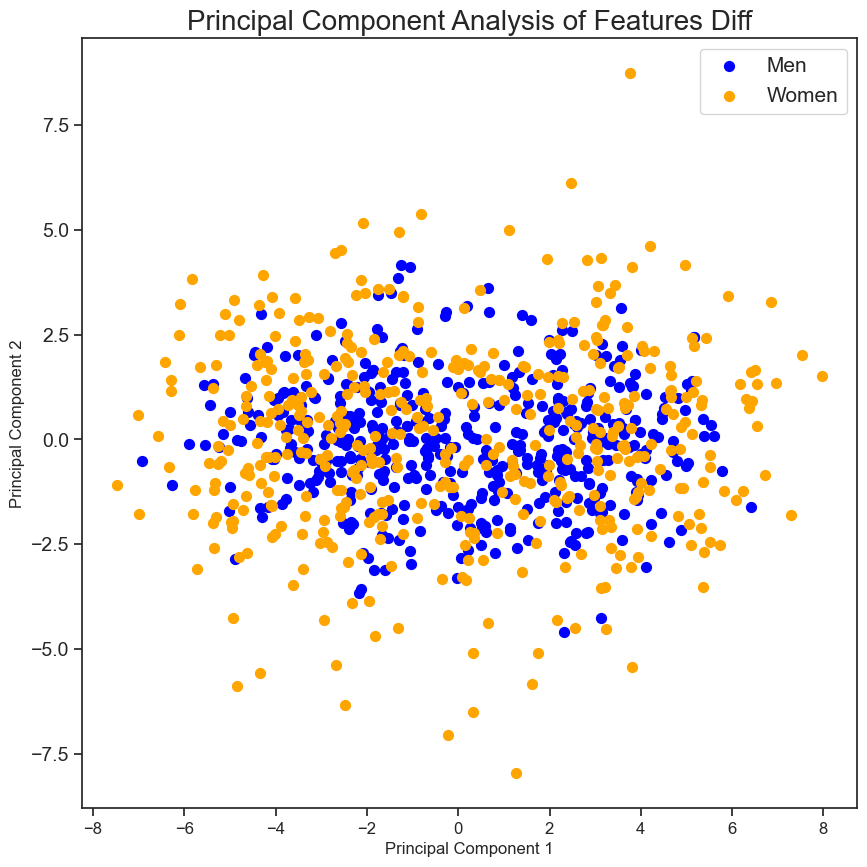

In [190]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Principal Component Analysis of Features Diff",fontsize=20)
targets = [True, False]
colors = ['blue', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = stats_df['men'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc_1'], pca_df.loc[indicesToKeep, 'pc_2'], c = color, s = 50)

plt.legend(['Men','Women'],prop={'size': 15});

In [46]:
stats_df.to_csv("data/df_progress.csv",index=False)